<a href="https://colab.research.google.com/github/dcastf01/audio_study/blob/main/audio_augmentation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!git clone https://github.com/dcastf01/Challenge_Ocean_2022.git

Cloning into 'Challenge_Ocean_2022'...
remote: Enumerating objects: 25, done.
remote: Counting objects: 100% (25/25), done.
remote: Compressing objects: 100% (19/19), done.
remote: Total 25 (delta 6), reused 15 (delta 3), pack-reused 0
Unpacking objects: 100% (25/25), done.


In [125]:
!pip install ffmpeg-python==0.2.0 torch-audiomentations

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 47 kB 2.7 MB/s 
     |████████████████████████████████| 59 kB 5.7 MB/s 
  Created wheel for julius: filename=julius-0.2.7-py3-none-any.whl size=21894 sha256=8b6380cd1a08e4d5d0cf1d695ea3b98ce0363225707a596419a9053bd1f8277a
  Stored in directory: /root/.cache/pip/wheels/44/52/2c/7dd069f82c7f905f40b190a8039ec2a17fdd4bb009c57c6664
Successfully built julius


In [3]:
cd Challenge_Ocean_2022/src

/content/Challenge_Ocean_2022/src


In [4]:
#@title setup
import io
import os
import math
import tarfile
import multiprocessing

import scipy
import librosa

import requests
import matplotlib
import matplotlib.pyplot as plt
import pandas as pd
import time
from IPython.display import Audio, display

[width, height] = matplotlib.rcParams['figure.figsize']
if width < 10:
  matplotlib.rcParams['figure.figsize'] = [width * 2.5, height]

_SAMPLE_DIR = "_sample_data"
SAMPLE_WAV_URL = "https://pytorch-tutorial-assets.s3.amazonaws.com/steam-train-whistle-daniel_simon.wav"
SAMPLE_WAV_PATH = os.path.join(_SAMPLE_DIR, "steam.wav")

SAMPLE_WAV_SPEECH_URL = "https://pytorch-tutorial-assets.s3.amazonaws.com/VOiCES_devkit/source-16k/train/sp0307/Lab41-SRI-VOiCES-src-sp0307-ch127535-sg0042.wav"
SAMPLE_WAV_SPEECH_PATH = os.path.join(_SAMPLE_DIR, "speech.wav")

SAMPLE_RIR_URL = "https://pytorch-tutorial-assets.s3.amazonaws.com/VOiCES_devkit/distant-16k/room-response/rm1/impulse/Lab41-SRI-VOiCES-rm1-impulse-mc01-stu-clo.wav"
SAMPLE_RIR_PATH = os.path.join(_SAMPLE_DIR, "rir.wav")

SAMPLE_NOISE_URL = "https://pytorch-tutorial-assets.s3.amazonaws.com/VOiCES_devkit/distant-16k/distractors/rm1/babb/Lab41-SRI-VOiCES-rm1-babb-mc01-stu-clo.wav"
SAMPLE_NOISE_PATH = os.path.join(_SAMPLE_DIR, "bg.wav")

SAMPLE_MP3_URL = "https://pytorch-tutorial-assets.s3.amazonaws.com/steam-train-whistle-daniel_simon.mp3"
SAMPLE_MP3_PATH = os.path.join(_SAMPLE_DIR, "steam.mp3")

SAMPLE_GSM_URL = "https://pytorch-tutorial-assets.s3.amazonaws.com/steam-train-whistle-daniel_simon.gsm"
SAMPLE_GSM_PATH = os.path.join(_SAMPLE_DIR, "steam.gsm")

SAMPLE_TAR_URL = "https://pytorch-tutorial-assets.s3.amazonaws.com/VOiCES_devkit.tar.gz"
SAMPLE_TAR_PATH = os.path.join(_SAMPLE_DIR, "sample.tar.gz")
SAMPLE_TAR_ITEM = "VOiCES_devkit/source-16k/train/sp0307/Lab41-SRI-VOiCES-src-sp0307-ch127535-sg0042.wav"

S3_BUCKET = "pytorch-tutorial-assets"
S3_KEY = "VOiCES_devkit/source-16k/train/sp0307/Lab41-SRI-VOiCES-src-sp0307-ch127535-sg0042.wav"

YESNO_DATASET_PATH = os.path.join(_SAMPLE_DIR, "yes_no")
os.makedirs(YESNO_DATASET_PATH, exist_ok=True)
os.makedirs(_SAMPLE_DIR, exist_ok=True)

def _fetch_data():
  uri = [
    (SAMPLE_WAV_URL, SAMPLE_WAV_PATH),
    (SAMPLE_WAV_SPEECH_URL, SAMPLE_WAV_SPEECH_PATH),
    (SAMPLE_RIR_URL, SAMPLE_RIR_PATH),
    (SAMPLE_NOISE_URL, SAMPLE_NOISE_PATH),
    (SAMPLE_MP3_URL, SAMPLE_MP3_PATH),
    (SAMPLE_GSM_URL, SAMPLE_GSM_PATH),
    (SAMPLE_TAR_URL, SAMPLE_TAR_PATH),
  ]
  for url, path in uri:
    with open(path, 'wb') as file_:
      file_.write(requests.get(url).content)

_fetch_data()

##Extract log spec with code from Whisper

La principal diferencia es que se aplican unos filtros de librosa, que se llama filters.mel con los siguientes argumentos 
sr=16000
n_fft=400
n_mels=80
This produces a linear transformation matrix to project FFT (Fast Fourier transform) bins onto Mel-frequency bins.



In [5]:
# path_audio='/content/84-121123-0000.flac'
path_audio=SAMPLE_WAV_SPEECH_PATH

In [6]:
from audio import load_audio,SAMPLE_RATE,N_FFT,HOP_LENGTH,mel_filters,N_MELS,log_mel_spectrogram
import matplotlib.pyplot as plt


In [7]:
def print_information_about_tensor(tensor):
    print('shape:',tensor.shape,'max',tensor.max(),'min',tensor.min())

def print_stats(waveform, sample_rate=None, src=None):
  if src:
    print("-" * 10)
    print("Source:", src)
    print("-" * 10)
  if sample_rate:
    print("Sample Rate:", sample_rate)
  print("Shape:", tuple(waveform.shape))
  print("Dtype:", waveform.dtype)
  print(f" - Max:     {waveform.max().item():6.3f}")
  print(f" - Min:     {waveform.min().item():6.3f}")
  print(f" - Mean:    {waveform.mean().item():6.3f}")
  print(f" - Std Dev: {waveform.std().item():6.3f}")
  print()
  print(waveform)
  print()

In [8]:
log_spec=log_mel_spectrogram(path_audio)
print_information_about_tensor(log_spec)
print("Sample rate",SAMPLE_RATE)

shape: torch.Size([80, 340]) max tensor(1.3501) min tensor(-0.6499)
Sample rate 16000


In [9]:
from IPython.display import Audio, display

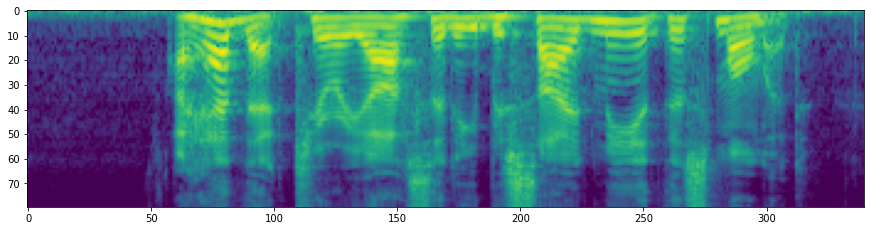

In [10]:
plt.imshow(log_spec)


##creating my own aumentation and analysis

basicamente sacado de aquí

In [11]:
import torch
import torchaudio
from IPython.display import Audio, display


In [12]:
waveform1,sample_rate1=torchaudio.load(path_audio)

In [13]:
print_information_about_tensor(waveform1)
print("Sample rate",sample_rate1)

shape: torch.Size([1, 54400]) max tensor(0.6682) min tensor(-1.0000)
Sample rate 16000


In [14]:
def plot_waveform(waveform, sample_rate, title="Waveform", xlim=None, ylim=None):
  waveform = waveform.numpy()

  num_channels, num_frames = waveform.shape
  time_axis = torch.arange(0, num_frames) / sample_rate

  figure, axes = plt.subplots(num_channels, 1)
  if num_channels == 1:
    axes = [axes]
  for c in range(num_channels):
    axes[c].plot(time_axis, waveform[c], linewidth=1)
    axes[c].grid(True)
    if num_channels > 1:
      axes[c].set_ylabel(f'Channel {c+1}')
    if xlim:
      axes[c].set_xlim(xlim)
    if ylim:
      axes[c].set_ylim(ylim)
  figure.suptitle(title)
  plt.show(block=False)

def plot_specgram(waveform, sample_rate, title="Spectrogram", xlim=None):
  waveform = waveform.numpy()

  num_channels, num_frames = waveform.shape
  time_axis = torch.arange(0, num_frames) / sample_rate

  figure, axes = plt.subplots(num_channels, 1)
  if num_channels == 1:
    axes = [axes]
  for c in range(num_channels):
    axes[c].specgram(waveform[c], Fs=sample_rate)
    if num_channels > 1:
      axes[c].set_ylabel(f'Channel {c+1}')
    if xlim:
      axes[c].set_xlim(xlim)
  figure.suptitle(title)
  plt.show(block=False)

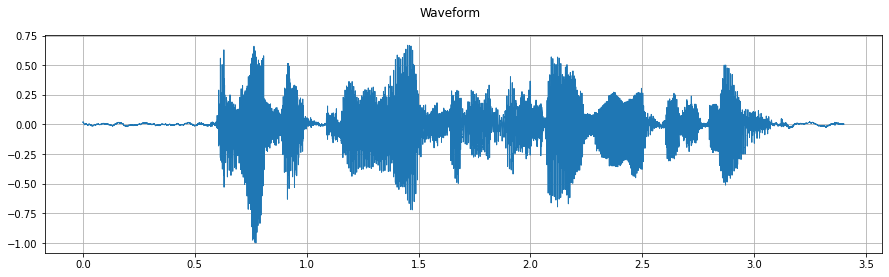

In [15]:
plot_waveform(waveform1,sample_rate1)

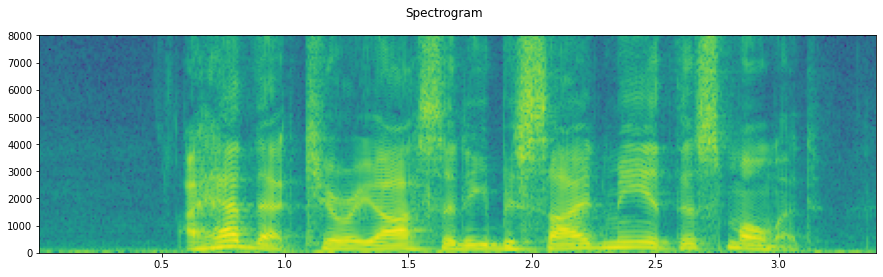

In [16]:
plot_specgram(waveform1,sample_rate1)

In [17]:
def play_audio(waveform, sample_rate):
  waveform = waveform.numpy()

  num_channels, num_frames = waveform.shape
  if num_channels == 1:
    display(Audio(waveform[0], rate=sample_rate))
  elif num_channels == 2:
    display(Audio((waveform[0], waveform[1]), rate=sample_rate))
  else:
    raise ValueError("Waveform with more than 2 channels are not supported.")

In [18]:
play_audio(waveform1,sample_rate1)


In [19]:
###resample
import torchaudio.transforms as T
# Define effects
effects = [
  ["lowpass", "-1", "300"], # apply single-pole lowpass filter
  ["speed", "0.8"],  # reduce the speed
                     # This only changes sample rate, so it is necessary to
                     # add `rate` effect with original sample rate after this.
  ["rate", f"{sample_rate1}"],
  ["reverb", "-w"],  # Reverbration gives some dramatic feeling
]

# Apply effects
waveform2, sample_rate2 = torchaudio.sox_effects.apply_effects_tensor(
    waveform1, sample_rate1, effects)

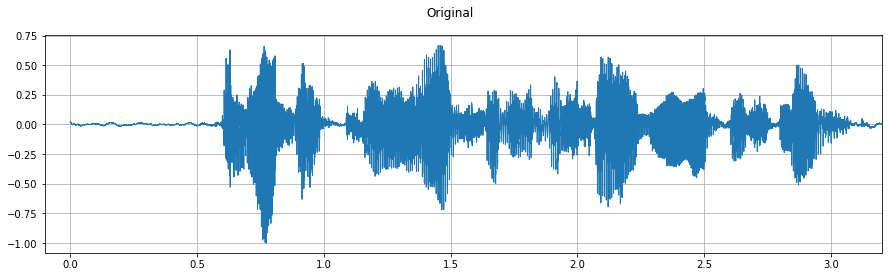

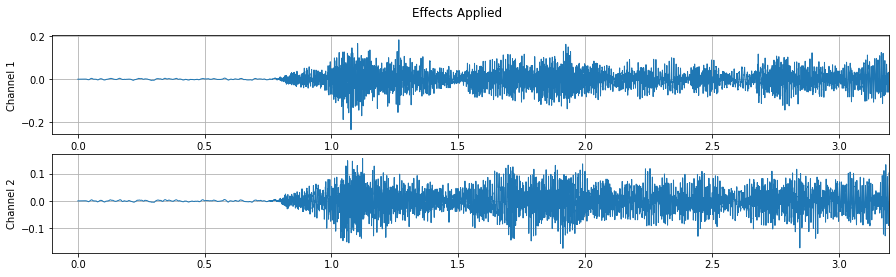

----------
Source: Original
----------
Sample Rate: 16000
Shape: (1, 54400)
Dtype: torch.float32
 - Max:      0.668
 - Min:     -1.000
 - Mean:     0.000
 - Std Dev:  0.122

tensor([[0.0183, 0.0180, 0.0180,  ..., 0.0018, 0.0019, 0.0032]])

----------
Source: Effects Applied
----------
Sample Rate: 16000
Shape: (2, 68000)
Dtype: torch.float32
 - Max:      0.182
 - Min:     -0.234
 - Mean:     0.000
 - Std Dev:  0.033

tensor([[0.0000, 0.0000, 0.0000,  ..., 0.0040, 0.0042, 0.0045],
        [0.0000, 0.0000, 0.0000,  ..., 0.0022, 0.0021, 0.0020]])



In [20]:
plot_waveform(waveform1, sample_rate1, title="Original", xlim=(-.1, 3.2))
plot_waveform(waveform2, sample_rate2, title="Effects Applied", xlim=(-.1, 3.2))
print_stats(waveform1, sample_rate=sample_rate1, src="Original")
print_stats(waveform2, sample_rate=sample_rate2, src="Effects Applied")

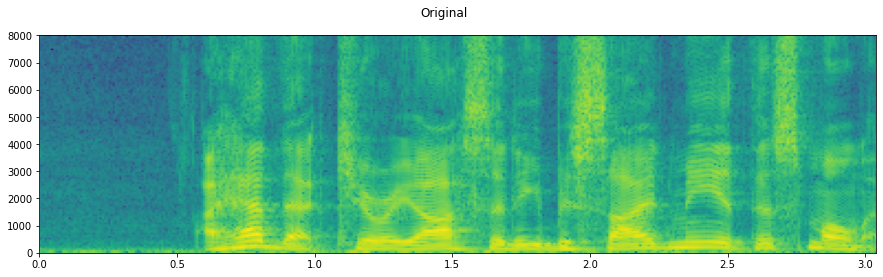

/usr/local/lib/python3.7/dist-packages/matplotlib/axes/_axes.py:7592: RuntimeWarning: divide by zero encountered in log10
  Z = 10. * np.log10(spec)


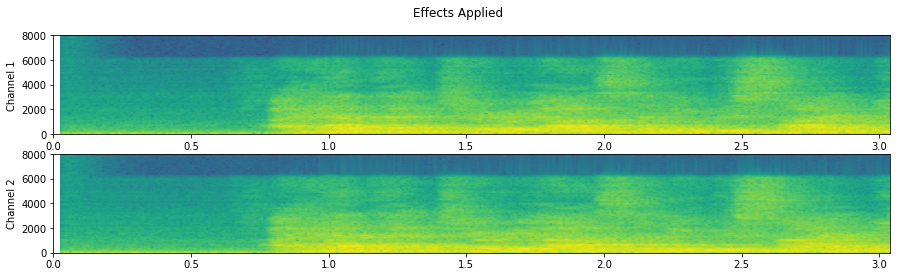

In [21]:
plot_specgram(waveform1, sample_rate1, title="Original", xlim=(0, 3.04))
play_audio(waveform1, sample_rate1)
plot_specgram(waveform2, sample_rate2, title="Effects Applied", xlim=(0, 3.04))
play_audio(waveform2, sample_rate2)

In [22]:
def _get_sample(path, resample=None):
  effects = [
    ["remix", "1"]
  ]
  if resample:
    effects.extend([
      ["lowpass", f"{resample // 2}"],
      ["rate", f'{resample}'],
    ])
  return torchaudio.sox_effects.apply_effects_file(path, effects=effects)
def get_speech_sample(*, resample=None):
  return _get_sample(SAMPLE_WAV_SPEECH_PATH, resample=resample)

def get_rir_sample(*, resample=None, processed=False):
  rir_raw, sample_rate = _get_sample(SAMPLE_RIR_PATH, resample=resample)
  if not processed:
    return rir_raw, sample_rate
  rir = rir_raw[:, int(sample_rate*1.01):int(sample_rate*1.3)]
  rir = rir / torch.norm(rir, p=2)
  rir = torch.flip(rir, [1])
  return rir, sample_rate

def get_noise_sample(*, resample=None):
  return _get_sample(SAMPLE_NOISE_PATH, resample=resample)

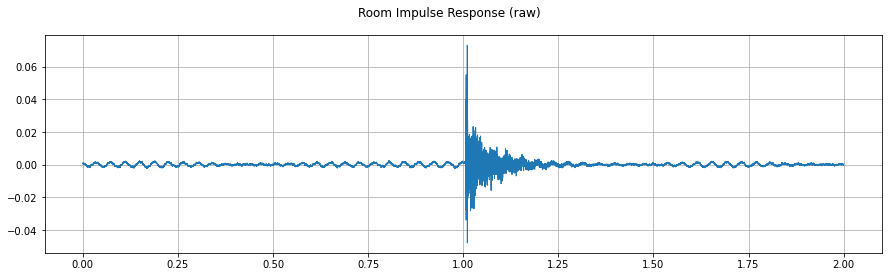

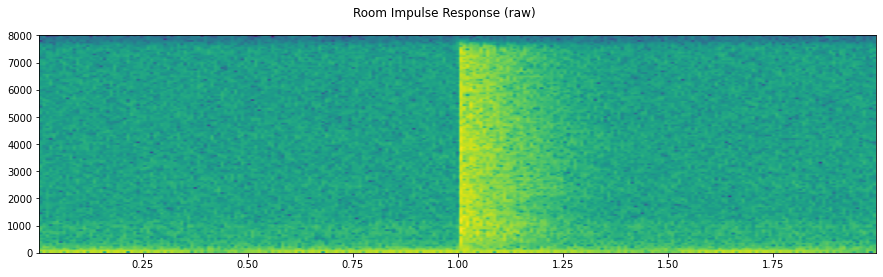

Shape: (1, 4640)
Dtype: torch.float32
 - Max:      0.263
 - Min:     -0.173
 - Mean:    -0.000
 - Std Dev:  0.015

tensor([[-0.0034, -0.0034, -0.0019,  ..., -0.0016,  0.0177,  0.0008]])



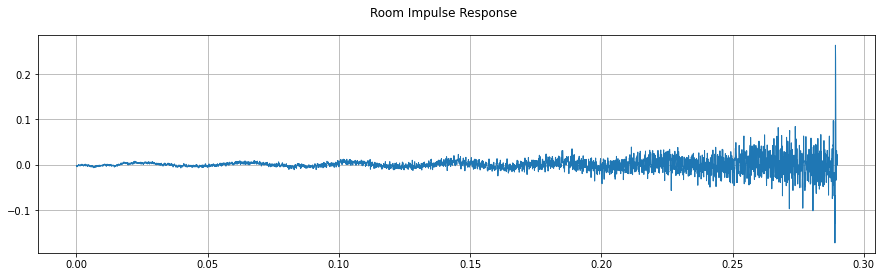

In [23]:
#Simulating room reverbratio
sample_rate=SAMPLE_RATE

rir_raw, _ = get_rir_sample(resample=sample_rate)

plot_waveform(rir_raw, sample_rate, title="Room Impulse Response (raw)", ylim=None)
plot_specgram(rir_raw, sample_rate, title="Room Impulse Response (raw)")
play_audio(rir_raw, sample_rate)

rir = rir_raw[:, int(sample_rate*1.01):int(sample_rate*1.3)]
rir = rir / torch.norm(rir, p=2)
rir = torch.flip(rir, [1])

print_stats(rir)
plot_waveform(rir, sample_rate, title="Room Impulse Response", ylim=None)

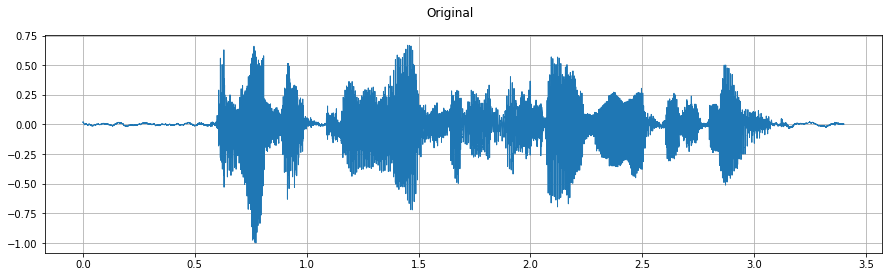

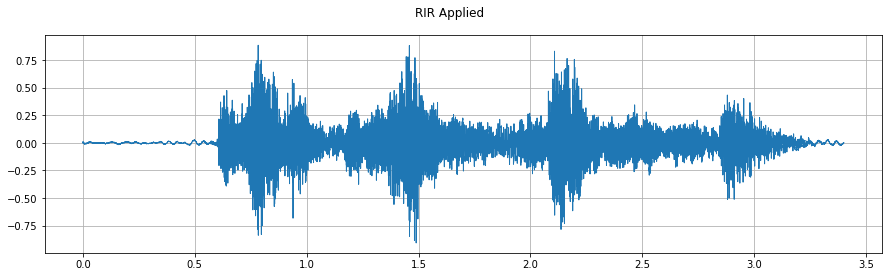

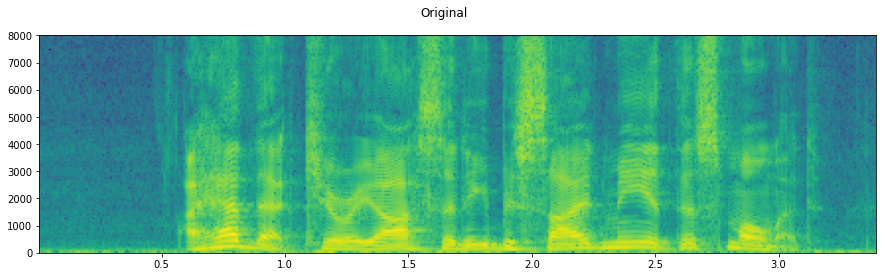

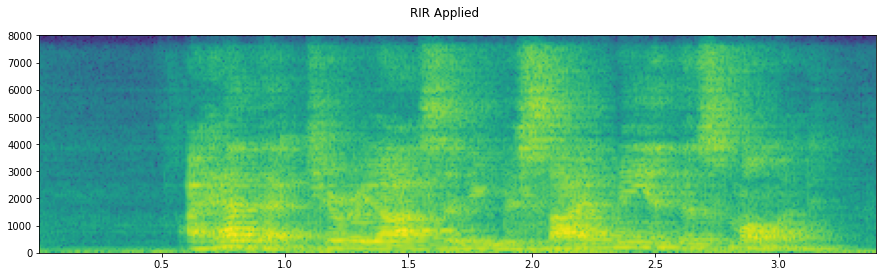

In [24]:

speech, _ = get_speech_sample(resample=sample_rate)

speech_ = torch.nn.functional.pad(speech, (rir.shape[1]-1, 0))
augmented = torch.nn.functional.conv1d(speech_[None, ...], rir[None, ...])[0]

plot_waveform(speech, sample_rate, title="Original", ylim=None)
plot_waveform(augmented, sample_rate, title="RIR Applied", ylim=None)

plot_specgram(speech, sample_rate, title="Original")
play_audio(speech, sample_rate)

plot_specgram(augmented, sample_rate, title="RIR Applied")
play_audio(augmented, sample_rate)

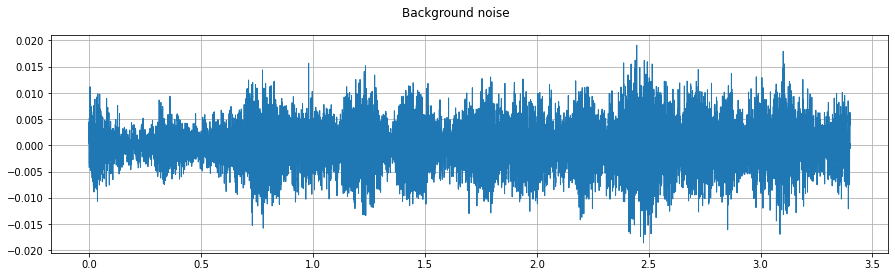

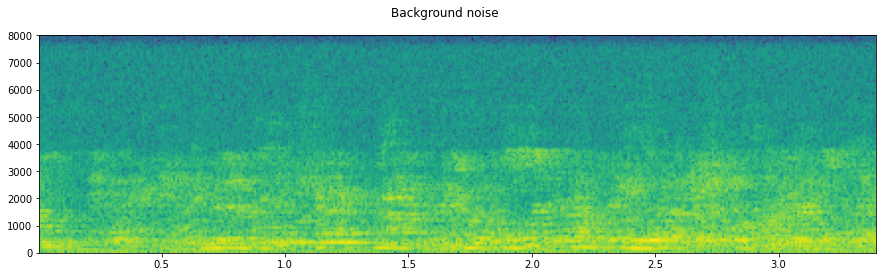

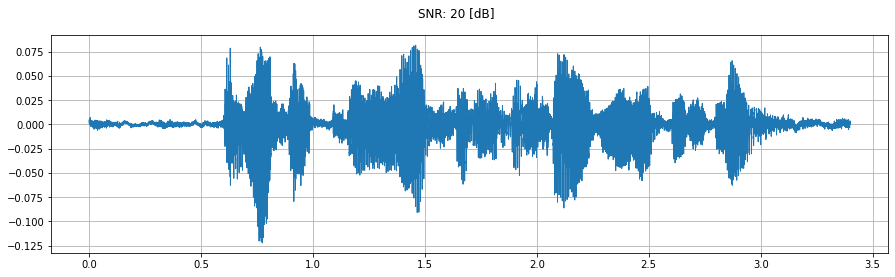

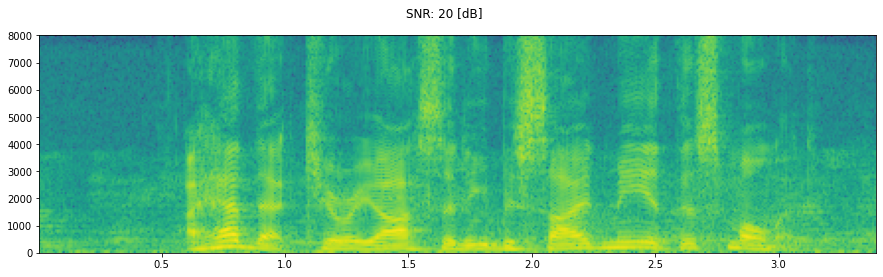

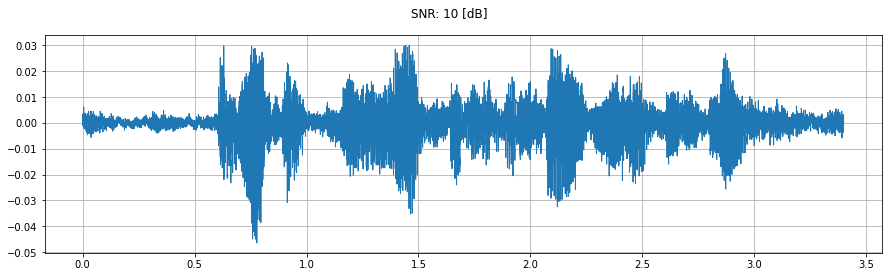

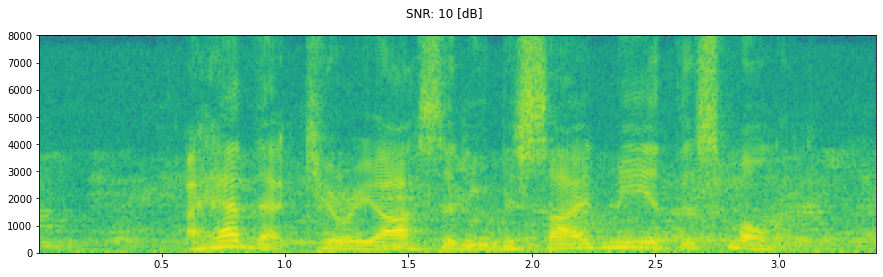

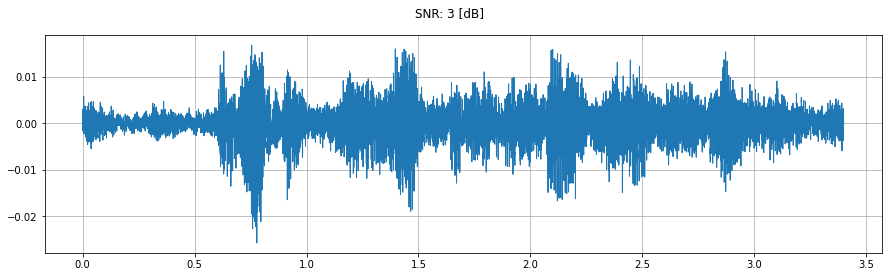

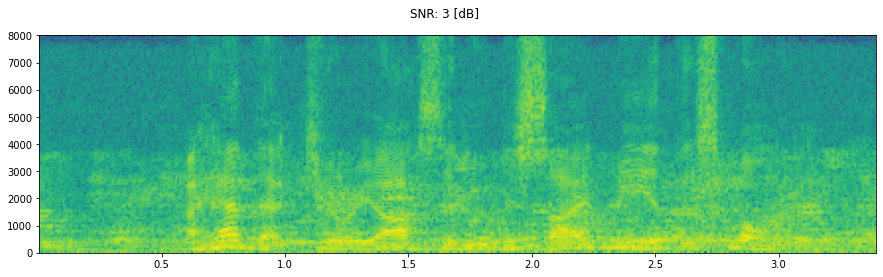

In [25]:
#adding background noise
speech, _ = get_speech_sample(resample=sample_rate)
noise, _ = get_noise_sample(resample=sample_rate)
noise = noise[:, :speech.shape[1]]

plot_waveform(noise, sample_rate, title="Background noise")
plot_specgram(noise, sample_rate, title="Background noise")
play_audio(noise, sample_rate)

speech_power = speech.norm(p=2)
noise_power = noise.norm(p=2)

for snr_db in [20, 10, 3]:
  snr = math.exp(snr_db / 10)
  scale = snr * noise_power / speech_power
  noisy_speech = (scale * speech + noise) / 2

  plot_waveform(noisy_speech, sample_rate, title=f"SNR: {snr_db} [dB]")
  plot_specgram(noisy_speech, sample_rate, title=f"SNR: {snr_db} [dB]")
  play_audio(noisy_speech, sample_rate)

##SpecAugment

In [39]:
def get_spectrogram(
    n_fft = 400,
    win_len = None,
    hop_len = None,
    power = 2.0,
):
  waveform, _ = get_speech_sample()
  spectrogram = T.Spectrogram(
      n_fft=n_fft,
      win_length=win_len,
      hop_length=hop_len,
      center=True,
      pad_mode="reflect",
      power=power,
  )
  return spectrogram(waveform)

def plot_spectrogram(spec, title=None, ylabel='freq_bin', aspect='auto', xmax=None):
  fig, axs = plt.subplots(1, 1)
  axs.set_title(title or 'Spectrogram (db)')
  axs.set_ylabel(ylabel)
  axs.set_xlabel('frame')
  im = axs.imshow(librosa.power_to_db(spec), origin='lower', aspect=aspect)
  if xmax:
    axs.set_xlim((0, xmax))
  fig.colorbar(im, ax=axs)
  plt.show(block=False)

def inverse_spectrogram(spec,
                        n_fft = 400,
    win_len = None,
    hop_len = None,
    power = 2.0,
    ):
    inverse_spectrogram = T.InverseSpectrogram(
      n_fft=n_fft,
      win_length=win_len,
      hop_length=hop_len,
      center=True,
      pad_mode="reflect",
  )
    return inverse_spectrogram(spec)

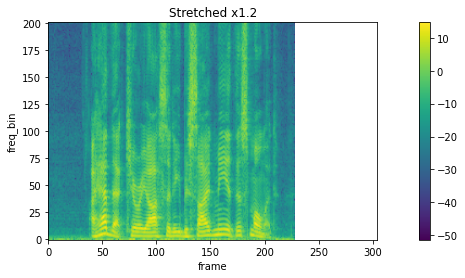

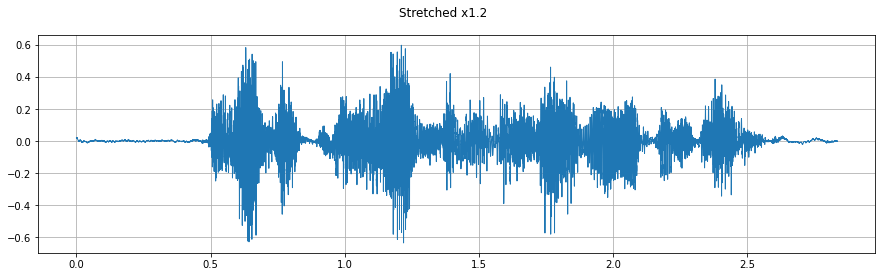

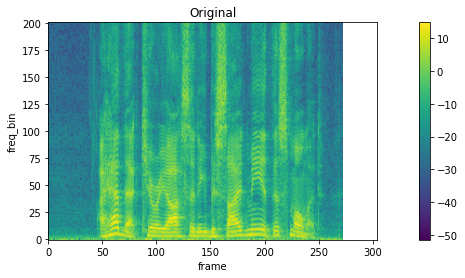

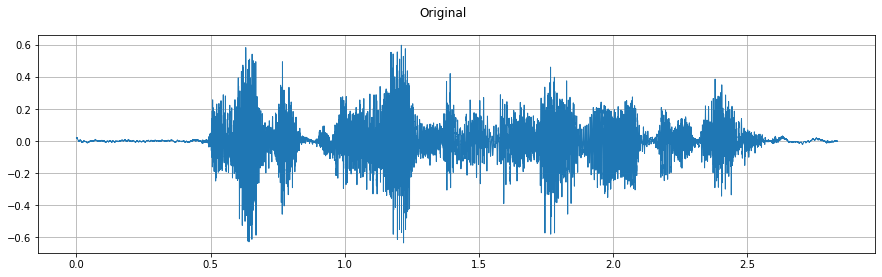

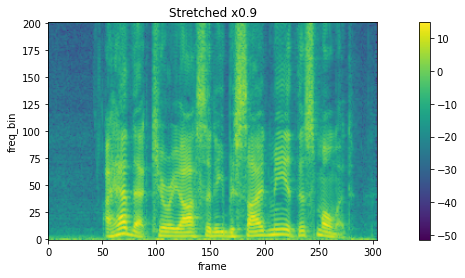

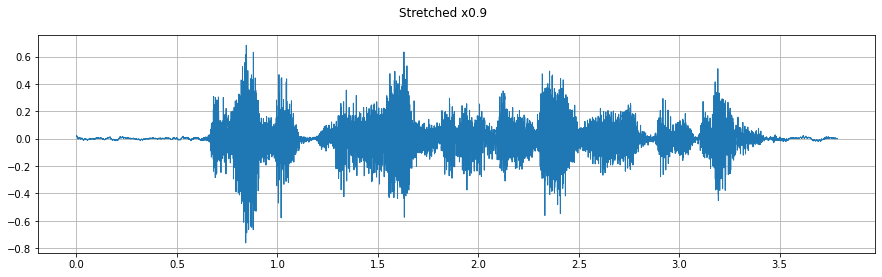

In [45]:
##TimeStretch
spec = get_spectrogram(power=None)
stretch = T.TimeStretch()

rate = 1.2
spec_ = stretch(spec, rate)
plot_spectrogram(torch.abs(spec_[0]), title=f"Stretched x{rate}", aspect="equal", xmax=304)
waveform=inverse_spectrogram(spec_)
plot_waveform(waveform, sample_rate, title=f"Stretched x{rate}")
play_audio(waveform, sample_rate)

plot_spectrogram(torch.abs(spec[0]), title="Original", aspect="equal", xmax=304)
waveform=inverse_spectrogram(spec_)
plot_waveform(waveform, sample_rate, title="Original")
play_audio(waveform, sample_rate)

rate = 0.9
spec_ = stretch(spec, rate)
plot_spectrogram(torch.abs(spec_[0]), title=f"Stretched x{rate}", aspect="equal", xmax=304)
waveform=inverse_spectrogram(spec_)
plot_waveform(waveform, sample_rate, title=f"Stretched x{rate}")
play_audio(waveform, sample_rate)

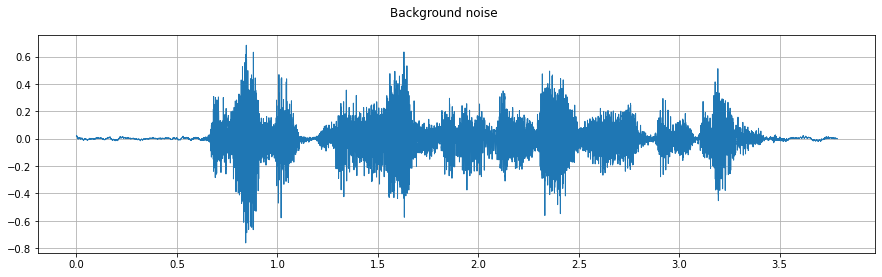

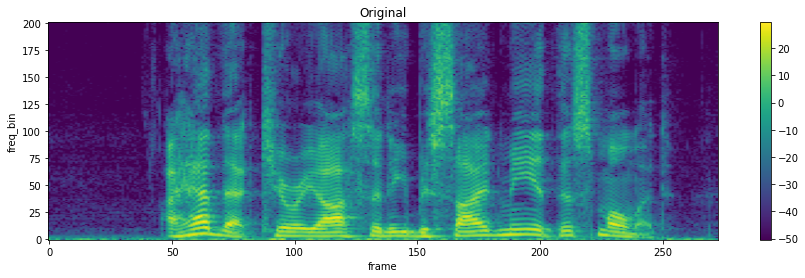

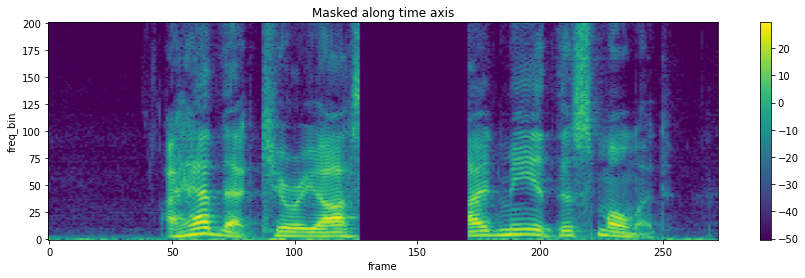

In [34]:
##TimeMasking
torch.random.manual_seed(4)

spec = get_spectrogram()
plot_spectrogram(spec[0], title="Original")

masking = T.TimeMasking(time_mask_param=80)
spec = masking(spec)

plot_spectrogram(spec[0], title="Masked along time axis")

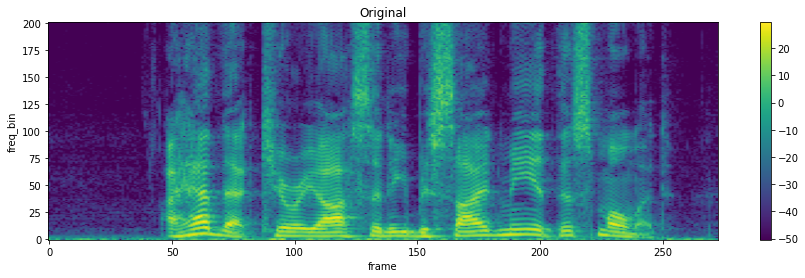

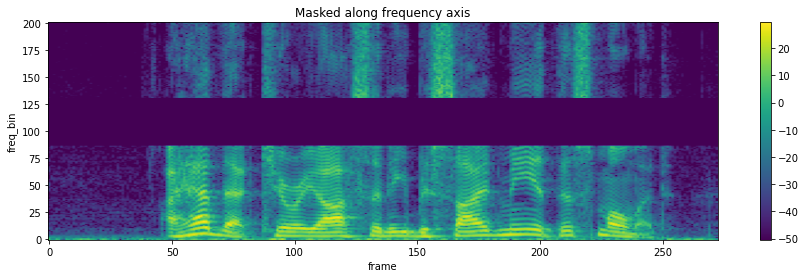

In [35]:
##FrequencyMasking
torch.random.manual_seed(4)

spec = get_spectrogram()
plot_spectrogram(spec[0], title="Original")

masking = T.FrequencyMasking(freq_mask_param=80)
spec = masking(spec)

plot_spectrogram(spec[0], title="Masked along frequency axis")

#Creating the transformations


In [144]:
#https://github.com/asteroid-team/torch-audiomentations but documentation https://iver56.github.io/audiomentations/ although not all the functios
import torch_audiomentations
from torch_audiomentations import Compose

def get_transform_to_waveform(p=0.5):
    transform_to_waveform=Compose(

        transforms=[
            # torch_audiomentations.AddBackgroundNoise(p=p),
            torch_audiomentations.BandPassFilter(p=p),
            torch_audiomentations.BandStopFilter(p=p),
            torch_audiomentations.AddColoredNoise(p=p),
            torch_audiomentations.Gain(p=p),
            torch_audiomentations.HighPassFilter(p=p),
            torch_audiomentations.Identity(p=p),
            # torch_audiomentations.ApplyImpulseResponse(p=p),
            torch_audiomentations.LowPassFilter(p=p),
            # torch_audiomentations.Mix(p=p),# Unreleased
            # torch_audiomentations.Padding(p=p), # Unreleased
            torch_audiomentations.PeakNormalization(p=p),
            # torch_audiomentations.PitchShift(p=p),
            torch_audiomentations.PolarityInversion(p=p),
            # torch_audiomentations.RandomCrop(p=p), # Unreleased
            torch_audiomentations.Shift(p=p),
            torch_audiomentations.ShuffleChannels(p=p),
            # torch_audiomentations.SpliceOut(p=p), # Unreleased
            torch_audiomentations.TimeInversion(p=p),
            
        ]
    )
    return transform_to_waveform
get_transform_to_waveform()

/usr/local/lib/python3.7/dist-packages/torch_audiomentations/core/transforms_interface.py:83: FutureWarning: Transforms now expect an `output_type` argument that currently defaults to 'tensor', will default to 'dict' in v0.12, and will be removed in v0.13. Make sure to update your code to something like:
  >>> augment = PolarityInversion(..., output_type='dict')
  >>> augmented_samples = augment(samples).samples
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/torch_audiomentations/core/transforms_interface.py:83: FutureWarning: Transforms now expect an `output_type` argument that currently defaults to 'tensor', will default to 'dict' in v0.12, and will be removed in v0.13. Make sure to update your code to something like:
  >>> augment = Shift(..., output_type='dict')
  >>> augmented_samples = augment(samples).samples
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/torch_audiomentations/core/transforms_interface.py:83: FutureWarning: Transforms now expect an `output_type

Compose(
  (transforms): ModuleList(
    (0): BandPassFilter()
    (1): BandStopFilter()
    (2): AddColoredNoise()
    (3): Gain()
    (4): HighPassFilter()
    (5): Identity()
    (6): LowPassFilter()
    (7): PeakNormalization()
    (8): PolarityInversion()
    (9): Shift()
    (10): ShuffleChannels()
    (11): TimeInversion()
  )
)

In [142]:
torch_audiomentations.__version__

'0.11.0'

#Creating class dataset

In [145]:
def load_audio(file: str, sr: int = SAMPLE_RATE):
    """
    Open an audio file and read as mono waveform, resampling as necessary

    Parameters
    ----------
    file: str
        The audio file to open

    sr: int
        The sample rate to resample the audio if necessary

    Returns
    -------
    A NumPy array containing the audio waveform, in float32 dtype.
    """
    try:
        # This launches a subprocess to decode audio while down-mixing and resampling as necessary.
        # Requires the ffmpeg CLI and `ffmpeg-python` package to be installed.
        out, _ = (
            ffmpeg.input(file, threads=0)
            .output("-", format="s16le", acodec="pcm_s16le", ac=1, ar=sr)
            .run(cmd="ffmpeg", capture_stdout=True, capture_stderr=True)
        )
        
    except ffmpeg.Error as e:
        raise RuntimeError(f"Failed to load audio: {e.stderr.decode()}") from e

    return np.frombuffer(out, np.int16).flatten().astype(np.float32) / 32768.0

In [146]:
from torch.utils.data import Dataset
from typing import Tuple, Union
from pathlib import Path
from torch import Tensor
from functools import lru_cache
import numpy as np
import fsspec
import ffmpeg


def exact_div(x, y):
    assert x % y == 0
    return x // y
SAMPLE_RATE = 16000
N_FFT = 400
N_MELS = 80
HOP_LENGTH = 160
CHUNK_LENGTH = 30
N_SAMPLES = CHUNK_LENGTH * SAMPLE_RATE  # 480000: number of samples in a chunk
N_FRAMES = exact_div(N_SAMPLES, HOP_LENGTH)  # 3000: number of frames in a mel spectrogram input



class AudioDataset(Dataset):
    _ext_audio = ".wav"
    _folder_audio = "wav"
     # hard-coded audio hyperparameters
    
    def __init__(
        self, root: Union[str, Path],transform_to_waveform=None,transform_to_spec=None
    ) -> None:
        #adapt depends on folder structure
        self.path=root
        self.transform_to_waveform=transform_to_waveform
        self.transform_to_spec=transform_to_spec
        object_to_manage_path = fsspec.open(self.path)
       
        
            
        self._walker = list(object_to_manage_path.fs.ls(self.path))

    def __len__(self):

        return len(self._walker)
    def __getitem__(self, n: int) -> Tuple[Tensor, int, str, str]:
        """Load the n-th sample from the dataset.

        Args:
            n (int): The index of the sample to be loaded

        Returns:
            (Tensor, int, str, str): ``(waveform, sample_rate, transcript, utterance_id)``
        """
        path = self._walker[n]
        # waveform,sample_rate=torchaudio.load(path_audio)
        waveform=load_audio(path)
        log_spec=self.preprocess_audio(waveform)

        return waveform,log_spec
    def preprocess_audio(self,audio:Union[str, np.ndarray, torch.Tensor], n_mels: int = N_MELS):
        if not torch.is_tensor(audio):
            if isinstance(audio, str):
                audio = load_audio(audio)
            audio = torch.from_numpy(audio)
        if self.transform_to_waveform:
            audio=self.transform_to_waveform(audio) 
        window = torch.hann_window(N_FFT).to(audio.device) #to find the properly windows to use in FT 
        stft = torch.stft(audio, N_FFT, HOP_LENGTH, window=window, return_complex=True) #Short-time Fourier transform (STFT).
        magnitudes = stft[:, :-1].abs() ** 2

        filters = self.mel_filters(audio.device, n_mels)

        mel_spec = filters @ magnitudes #@ in place of .matmul
        if self.transform_to_spec:
            mel_spec=self.transform_to_spec(mel_spec)
        log_spec = torch.clamp(mel_spec, min=1e-10).log10()
        log_spec = torch.maximum(log_spec, log_spec.max() - 8.0)
        log_spec = (log_spec + 4.0) / 4.0
        
        return log_spec

    def mel_filters(self,device, n_mels: int = N_MELS) -> torch.Tensor:
        """
        load the mel filterbank matrix for projecting STFT into a Mel spectrogram.
        Allows decoupling librosa dependency; saved using:

            np.savez_compressed(
                "mel_filters.npz",
                mel_80=librosa.filters.mel(sr=16000, n_fft=400, n_mels=80),
            )
        """
        assert n_mels == 80, f"Unsupported n_mels: {n_mels}"
        with np.load(os.path.join(os.path.dirname('/content/Challenge_Ocean_2022/src/'), "assets", "mel_filters.npz")) as f:
            return torch.from_numpy(f[f"mel_{n_mels}"]).to(device)




In [149]:
path='/content/Challenge_Ocean_2022/src/_sample_data'

transform=get_transform_to_waveform()
dataset=AudioDataset(path,transform)

/usr/local/lib/python3.7/dist-packages/torch_audiomentations/core/transforms_interface.py:83: FutureWarning: Transforms now expect an `output_type` argument that currently defaults to 'tensor', will default to 'dict' in v0.12, and will be removed in v0.13. Make sure to update your code to something like:
  >>> augment = BandPassFilter(..., output_type='dict')
  >>> augmented_samples = augment(samples).samples
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/torch_audiomentations/core/transforms_interface.py:83: FutureWarning: Transforms now expect an `output_type` argument that currently defaults to 'tensor', will default to 'dict' in v0.12, and will be removed in v0.13. Make sure to update your code to something like:
  >>> augment = BandStopFilter(..., output_type='dict')
  >>> augmented_samples = augment(samples).samples
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/torch_audiomentations/core/transforms_interface.py:83: FutureWarning: Transforms now expect an `outpu

In [150]:

for i in range(0,len(dataset)):
    print('i',i)
    try:
        magnitudes,filters=dataset[i]
        print(magnitudes.shape)
        print_information_about_tensor(magnitudes)
        print(len(filters))
        print_information_about_tensor(filters[0])
        print_information_about_tensor(filters[1])

        
    except Exception as e:
        print (e)

i 0
torch-audiomentations expects three-dimensional input tensors, with dimension ordering like [batch_size, num_channels, num_samples]. If your audio is mono, you can use a shape like [batch_size, 1, num_samples].
i 1
Failed to load audio: ffmpeg version 3.4.11-0ubuntu0.1 Copyright (c) 2000-2022 the FFmpeg developers
  built with gcc 7 (Ubuntu 7.5.0-3ubuntu1~18.04)
  configuration: --prefix=/usr --extra-version=0ubuntu0.1 --toolchain=hardened --libdir=/usr/lib/x86_64-linux-gnu --incdir=/usr/include/x86_64-linux-gnu --enable-gpl --disable-stripping --enable-avresample --enable-avisynth --enable-gnutls --enable-ladspa --enable-libass --enable-libbluray --enable-libbs2b --enable-libcaca --enable-libcdio --enable-libflite --enable-libfontconfig --enable-libfreetype --enable-libfribidi --enable-libgme --enable-libgsm --enable-libmp3lame --enable-libmysofa --enable-libopenjpeg --enable-libopenmpt --enable-libopus --enable-libpulse --enable-librubberband --enable-librsvg --enable-libshine --

In [112]:
magnitudes

array([0.01831055, 0.01803589, 0.01797485, ..., 0.00183105, 0.00189209,
       0.00320435], dtype=float32)

In [113]:
filters

(tensor([[5.4815e+00, 4.9924e-01, 3.1310e-02,  ..., 2.7674e+00, 1.3750e+00,
          5.2155e-01],
         [3.6053e+00, 5.2770e-02, 1.8118e-01,  ..., 8.3896e-01, 3.5467e-01,
          1.5540e-01],
         [8.1372e-01, 2.6083e-01, 1.7856e-01,  ..., 6.1882e-03, 2.2123e-03,
          7.6947e-03],
         ...,
         [1.7497e-06, 1.1873e-06, 8.7333e-07,  ..., 9.8672e-07, 6.2426e-07,
          1.5097e-06],
         [6.9047e-06, 6.9530e-06, 3.6293e-06,  ..., 1.4487e-06, 6.0659e-06,
          2.8127e-06],
         [2.4680e-05, 2.1519e-05, 7.1027e-06,  ..., 1.1591e-07, 1.2131e-05,
          2.1169e-08]]),
 tensor([[0.0000, 0.0249, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0020, 0.0229,  ..., 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0040,  ..., 0.0000, 0.0000, 0.0000],
         ...,
         [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000,  ..., 0.0009, 0.0